**Introduction**  
In this notebook will be dealt classification task using fully connected neural networks. The goal is to predict binary feature "Outcome", that represents whether a patient has diabetes or not,  basing on different indicators of patient health.  

Description of independent features of a dataset:      
Pregnancies - a number of times a patient was pregnant;  
Glucose - a level of glucose in patient's blood;  
BloodPressure - a blood pressure value of patient;   
SkinThickness - patient's thickness of skin;  
Insulin - level of insulin of a patient;  
BMI - bmi value of a patient;  
DiabetesPedigreeFunction - indicator of patient's predisposition to have diabetes;  
Age - represents age of patient.
  
Dependent(Target) feature:  
Outcome - if 1-> patient has diabetes, 0 in other case.    


---



**Importing libraries**

In [ ]:
!pip install pytorch-lightning

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl

**Downloading dateset**

In [ ]:
col_names = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
data = pd.read_csv(url, header=None, names=col_names)

In [ ]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [ ]:
data.shape

(768, 9)

The dataset does not contain a lot of records, the dataset is small. There are 8 independent features, 1 dependent.

In [ ]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Can be seen that features: "Gluscose", "BloodPressure", "SkinThickness", "Insulin", "BMI" strangely have statistic(minimal value) equal to zero. This is not possible for those features to take on such a value in real life. Value 0 for above mentioned features can be interpreted as a substituter of NaN. (Zeros should be replaced with appropriate strategy)

All features are of different ranges, scales, so will be applied to features normalization or standardization before fitting a model.

All features can be considered as significant, as not a one has very small standard deviation value.(for now)


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


Seems like dataset features does not contain missing values. That needs further verification.(As was previously mentioned, some features hide their Nans in zero values)

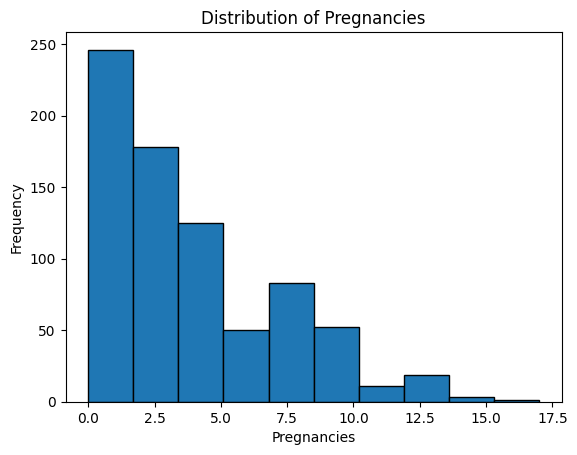

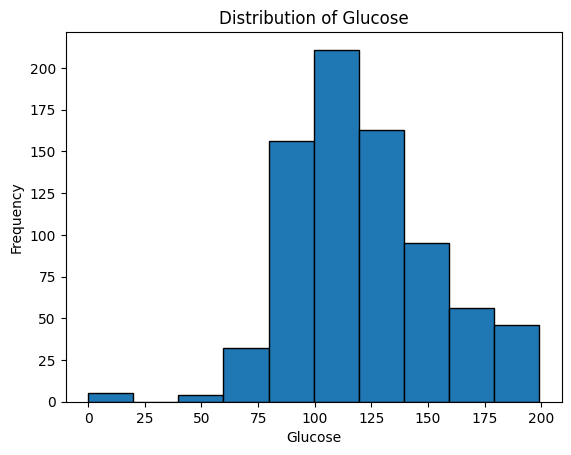

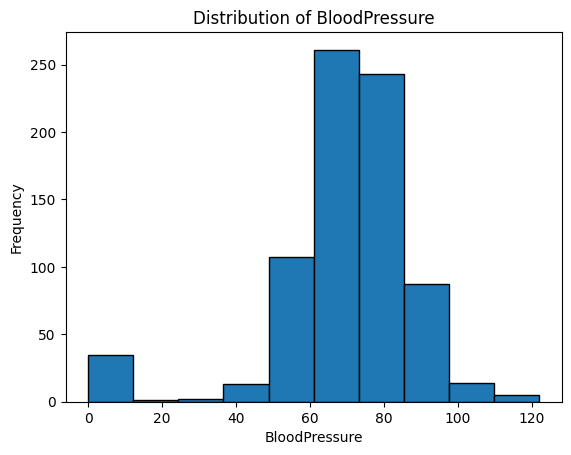

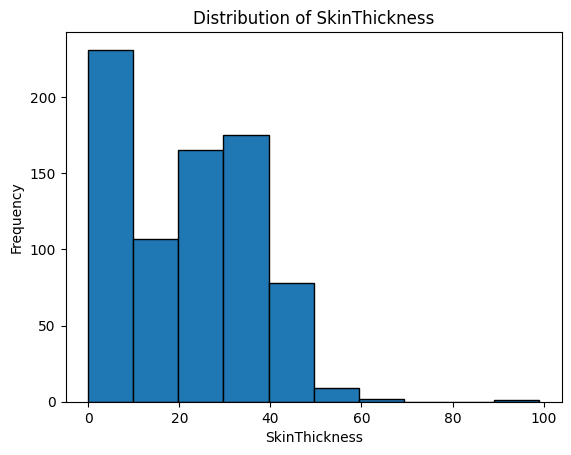

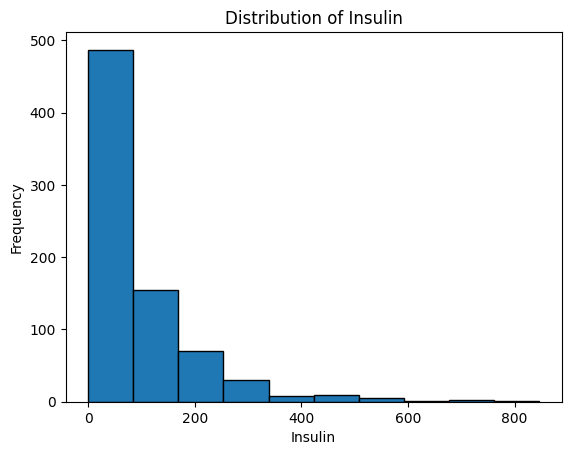

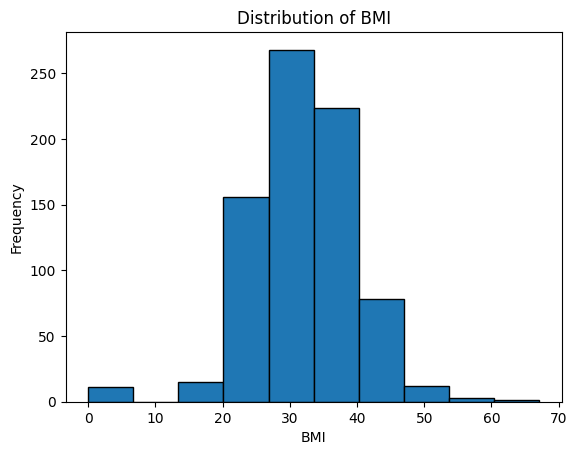

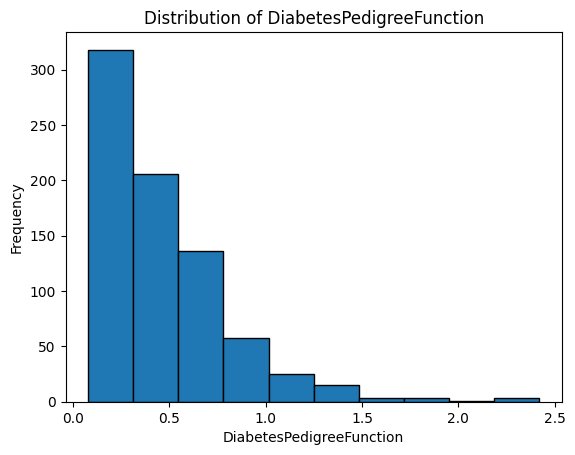

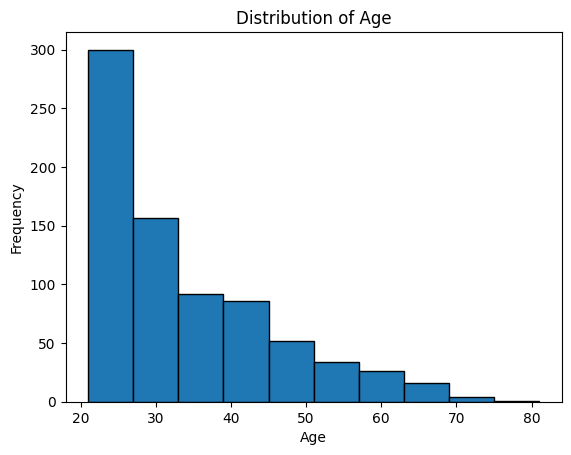

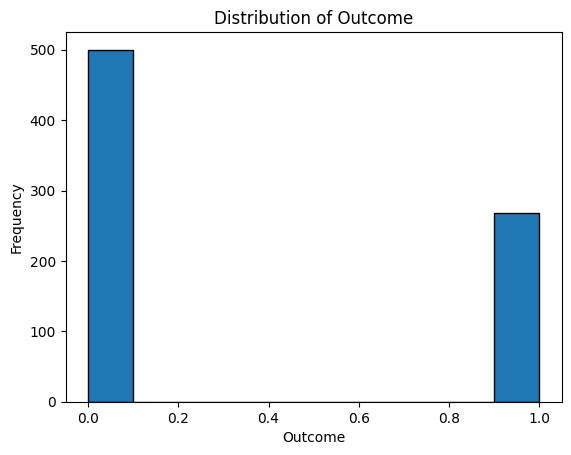

In [ ]:
for column in data.columns:
    plt.figure()
    data[column].plot(kind='hist', edgecolor='black')
    plt.title(f"Distribution of {column}")
    plt.xlabel(column)
    plt.ylabel("Frequency")
    plt.show()

Can be noticed that features "BMI", "Insulin", "SkinThickness", "BloodPressure", "Glucose" take on occasionaly values of 0, which is unrealistic. Value zero can be treated as holder value for Nans. This value in mentioned features should be replaced.

Distribution of feature "BloodPressure" looks symmetric (except small peak around zero).
Distribution of feature "Insulin", "BMI", "DiabetesPedigreeFunction", "Age", "Pregnancies" resemble exponential distribution.

Significant disproportion of target classes exist in dataset, as can be seen from plot of feature "Outcome". There are more instances in dataset , reprsenting non diabetic patients.

In [ ]:
def percentage_of_zeros_in_columns(data, columns):
    zero_percentage = {}
    for column in columns:
        zero_count = (data[column] == 0).sum()
        total_count = len(data[column])
        zero_percentage[column] = (zero_count / total_count) * 100
    return zero_percentage

In [ ]:
columns = ['BMI', 'Insulin', "SkinThickness", "BloodPressure", "Glucose"]
zero_percentages = percentage_of_zeros_in_columns(data, columns)
print(zero_percentages)

{'BMI': 1.4322916666666665, 'Insulin': 48.69791666666667, 'SkinThickness': 29.557291666666668, 'BloodPressure': 4.557291666666666, 'Glucose': 0.6510416666666667}


Features "Insulin" and "SkinThickness" comprise mainly of zeros (around 49% of all values are zeros for "Insulin" and around 30% of values are zeros for "SkinThickness"). These features will be dropped as mostly(or significant part of them) they contain invalied values ("SkinThickness" parameter cannot be of zero value, as well as level of insulin in patient's body).

In the following code cell will be performed data preparation, pipeline will be used. First of all, as was mentioned earlier respectful columns will be deleted. Then in columns: "BMI", "BloodPressure", "Glucose" zero values will be replaces with mean values of those columns. (This strategy will not introduce to much artificial feature values; as those columns contain not much zero values) And afterall will be performed converting to torch tensors.

After that data will be partitioned on training(80% of initial dataset volume) and test(20% of initial dataset volume) sets.

In [ ]:
target_column = "Outcome"
columns_to_drop = ["Insulin", "SkinThickness"]
columns_to_impute = ["BMI", "BloodPressure", "Glucose"]

def to_torch_tensor(X):
    return torch.tensor(X, dtype=torch.float32)
tensor_transformer = FunctionTransformer(to_torch_tensor)

def drop_columns(X):
    return X.drop(columns=columns_to_drop)
dropper = FunctionTransformer(drop_columns)

pipeline = Pipeline([
    ('dropper', dropper),

    ('imputer', ColumnTransformer(
        transformers=[
            ('impute_zeros', SimpleImputer(missing_values=0, strategy='mean'), columns_to_impute)
        ],
        remainder='passthrough'
    )),

    ('scaler', MinMaxScaler()),

    ('to_tensor', tensor_transformer)
])

X = data.drop(columns=[target_column])
y = data[target_column]

X_tensor = pipeline.fit_transform(X)
y_tensor = torch.tensor(y.values, dtype=torch.float32).view(-1, 1)

The partitioning of dataset on training and testing will be performed in such a way so to keep same the proportion of instances with different target classes values in both training and testing sets.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=1, stratify=y_tensor)

**Fitting models**  
PyTorch

Mainly will be tried three different neural networks architectures. The first one will be classical one, with only one hidden layer.
The second will be , so called "wide" neural network and the last one, will be so called "deep" neural network with. The architecture of "wide" neural network implies that network has large number of neurons and small number of hidden layers. In contrary, the architecture of "deep" neural netwok implies that there are a lot of hidden layers in neural network, as well as a lot of neurons. Such architectures are standard, well-known, in some way classical, that is why they were have chosen.

Comparison of those different neural networks will be conducted. The comparison metric that will be used - accuracy. (Though it clear that such a metric is not very good in our classification task, to assess algorithm, as was seen that there exist imbalance of target classes in dataset. accuracy is used as our goal is to just compare models).

Will be used different hyperparamaters (learning rates and number of training epochs) for each neural network architecture.

In [ ]:
class SmallNet(nn.Module):
  def __init__(self, input_size):
        print("SMALL")
        super(SmallNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 24),
            nn.ReLU(),
            nn.Linear(24, 1),
            nn.Sigmoid()
        )

  def forward(self, x):
        return self.model(x)

class WideNet(nn.Module):
    def __init__(self, input_size):
        print("WIDE")
        super(WideNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 180),
            nn.ReLU(),
            nn.Linear(180, 120),
            nn.ReLU(),
            nn.Linear(120, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

class DeepNet(nn.Module):
    def __init__(self, input_size):
        print("DEEP")
        super(DeepNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 60),
            nn.ReLU(),
            nn.Linear(60, 60),
            nn.ReLU(),
            nn.Linear(60, 60),
            nn.ReLU(),
            nn.Linear(60, 40),
            nn.ReLU(),
            nn.Linear(40, 40),
            nn.ReLU(),
            nn.Linear(40, 40),
            nn.ReLU(),
            nn.Linear(40, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
def train_test_net(X_train, y_train, X_test, y_test, model_class, n_epochs, lr, batch_size=32):
    input_size = X_train.shape[1]
    model = model_class(input_size)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(n_epochs):
        model.train()

        for batch in train_loader:
            x_batch, y_batch = batch
            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

        if (epoch + 1) % 10 == 0:
            predicted_classes = (outputs >= 0.5).float()
            accuracy = (predicted_classes == y_batch).float().mean()
            print(f"Epoch [{epoch + 1}/{n_epochs}], Loss: {loss.item():.4f}, Train Accuracy: {accuracy:.4f}")

    model.eval()
    with torch.no_grad():
        predictions = model(X_test)
        predicted_classes = (predictions >= 0.5).float()
        accuracy = (predicted_classes == y_test).float().mean()
        print(f"Test Accuracy: {accuracy:.4f}")

**Classical neural network architecture**

In [ ]:
train_test_net(X_train, y_train, X_test, y_test, SmallNet, 100, 1)

SMALL
Epoch [10/100], Loss: 0.3973, Train Accuracy: 1.0000
Epoch [20/100], Loss: 0.8907, Train Accuracy: 0.1667
Epoch [30/100], Loss: 0.8845, Train Accuracy: 0.3333
Epoch [40/100], Loss: 0.6482, Train Accuracy: 0.6667
Epoch [50/100], Loss: 0.7202, Train Accuracy: 0.5000
Epoch [60/100], Loss: 0.6426, Train Accuracy: 0.6667
Epoch [70/100], Loss: 0.4548, Train Accuracy: 1.0000
Epoch [80/100], Loss: 0.6099, Train Accuracy: 0.8333
Epoch [90/100], Loss: 0.7038, Train Accuracy: 0.1667
Epoch [100/100], Loss: 0.4961, Train Accuracy: 0.8333
Test Accuracy: 0.6494


As seen, test accuracy is a little bit better than for random guesser (it is first, baseline neural network with classical architecture, very small and simple). It will be tried to decrease learning rate and increase number of epochs to improve model perfomance.

In [ ]:
train_test_net(X_train, y_train, X_test, y_test, SmallNet, 200, 0.1)

SMALL
Epoch [10/200], Loss: 0.3020, Train Accuracy: 0.8333
Epoch [20/200], Loss: 0.1000, Train Accuracy: 1.0000
Epoch [30/200], Loss: 0.3856, Train Accuracy: 0.8333
Epoch [40/200], Loss: 0.4340, Train Accuracy: 0.8333
Epoch [50/200], Loss: 0.2580, Train Accuracy: 1.0000
Epoch [60/200], Loss: 0.2263, Train Accuracy: 1.0000
Epoch [70/200], Loss: 0.3002, Train Accuracy: 0.8333
Epoch [80/200], Loss: 0.2088, Train Accuracy: 0.8333
Epoch [90/200], Loss: 0.3544, Train Accuracy: 0.8333
Epoch [100/200], Loss: 0.2818, Train Accuracy: 0.8333
Epoch [110/200], Loss: 0.2274, Train Accuracy: 0.8333
Epoch [120/200], Loss: 0.1854, Train Accuracy: 1.0000
Epoch [130/200], Loss: 0.2806, Train Accuracy: 1.0000
Epoch [140/200], Loss: 0.4719, Train Accuracy: 0.6667
Epoch [150/200], Loss: 0.1976, Train Accuracy: 1.0000
Epoch [160/200], Loss: 0.4405, Train Accuracy: 0.6667
Epoch [170/200], Loss: 0.8072, Train Accuracy: 0.5000
Epoch [180/200], Loss: 0.6855, Train Accuracy: 0.3333
Epoch [190/200], Loss: 0.4882, 

And indeed, as can be seen model's accuracy on test set increased, after choosing different hyperparameters. Let's investigate whether further decreasing of learning rate will make model perfomance any better.  

In [ ]:
train_test_net(X_train, y_train, X_test, y_test, SmallNet, 200, 0.01)

SMALL
Epoch [10/200], Loss: 0.1743, Train Accuracy: 1.0000
Epoch [20/200], Loss: 0.7276, Train Accuracy: 0.6667
Epoch [30/200], Loss: 0.5032, Train Accuracy: 0.8333
Epoch [40/200], Loss: 0.1920, Train Accuracy: 1.0000
Epoch [50/200], Loss: 0.5776, Train Accuracy: 0.6667
Epoch [60/200], Loss: 0.4041, Train Accuracy: 1.0000
Epoch [70/200], Loss: 0.4955, Train Accuracy: 0.8333
Epoch [80/200], Loss: 0.7733, Train Accuracy: 0.6667
Epoch [90/200], Loss: 0.1733, Train Accuracy: 1.0000
Epoch [100/200], Loss: 0.4266, Train Accuracy: 0.6667
Epoch [110/200], Loss: 0.2655, Train Accuracy: 1.0000
Epoch [120/200], Loss: 0.3303, Train Accuracy: 0.8333
Epoch [130/200], Loss: 0.3154, Train Accuracy: 0.8333
Epoch [140/200], Loss: 0.0964, Train Accuracy: 1.0000
Epoch [150/200], Loss: 0.4187, Train Accuracy: 0.8333
Epoch [160/200], Loss: 0.4141, Train Accuracy: 0.8333
Epoch [170/200], Loss: 0.5453, Train Accuracy: 0.6667
Epoch [180/200], Loss: 0.2893, Train Accuracy: 0.8333
Epoch [190/200], Loss: 0.7537, 

After decreasing learning rate, the perfomance got even better, which suggest that the learning rate of value 0.01 gives best convergence towards minimum of loss function (in combination with hyperparameter n_epochs = 200).

**Wide neural network architecture**

In [ ]:
train_test_net(X_train, y_train, X_test, y_test, WideNet, 100, 1)

WIDE
Epoch [10/100], Loss: 33.3333, Train Accuracy: 0.6667
Epoch [20/100], Loss: 16.6667, Train Accuracy: 0.8333
Epoch [30/100], Loss: 33.3333, Train Accuracy: 0.6667
Epoch [40/100], Loss: 66.6667, Train Accuracy: 0.3333
Epoch [50/100], Loss: 33.3333, Train Accuracy: 0.6667
Epoch [60/100], Loss: 33.3333, Train Accuracy: 0.6667
Epoch [70/100], Loss: 16.6667, Train Accuracy: 0.8333
Epoch [80/100], Loss: 16.6667, Train Accuracy: 0.8333
Epoch [90/100], Loss: 33.3333, Train Accuracy: 0.6667
Epoch [100/100], Loss: 50.0000, Train Accuracy: 0.5000
Test Accuracy: 0.6494


And again, test accuracy suggest, that the model is just a little better than random classifier. So, will be tried again to increase number of epochs during which model is training , as well as to decrease learning rate(which allows model to more conservatively, slowly converge to minimum).

Here, can be observed that loss values went significantly higher comparing to previous two models(that might indicate that model underfits training set).

In [ ]:
train_test_net(X_train, y_train, X_test, y_test, WideNet, 200, 0.1)

WIDE
Epoch [10/200], Loss: 0.7426, Train Accuracy: 0.6667
Epoch [20/200], Loss: 0.3146, Train Accuracy: 1.0000
Epoch [30/200], Loss: 0.8109, Train Accuracy: 0.5000
Epoch [40/200], Loss: 0.2238, Train Accuracy: 0.8333
Epoch [50/200], Loss: 0.4433, Train Accuracy: 0.8333
Epoch [60/200], Loss: 0.4525, Train Accuracy: 0.6667
Epoch [70/200], Loss: 0.3154, Train Accuracy: 0.8333
Epoch [80/200], Loss: 0.6047, Train Accuracy: 0.6667
Epoch [90/200], Loss: 0.8163, Train Accuracy: 0.5000
Epoch [100/200], Loss: 0.8209, Train Accuracy: 0.6667
Epoch [110/200], Loss: 0.5654, Train Accuracy: 0.6667
Epoch [120/200], Loss: 0.2829, Train Accuracy: 0.8333
Epoch [130/200], Loss: 0.5270, Train Accuracy: 0.6667
Epoch [140/200], Loss: 0.4641, Train Accuracy: 0.6667
Epoch [150/200], Loss: 0.2056, Train Accuracy: 0.8333
Epoch [160/200], Loss: 0.6141, Train Accuracy: 0.6667
Epoch [170/200], Loss: 0.3205, Train Accuracy: 0.8333
Epoch [180/200], Loss: 0.5261, Train Accuracy: 0.6667
Epoch [190/200], Loss: 0.1885, T

So, as can be seen , choosing different setup of hyperparameters helped to increase testing accuracy.  
The testing accuracy value is a little bit worse comparing to best version of classical neural network, that was shown earlier. Values of loss function during training have normalized.

In [ ]:
train_test_net(X_train, y_train, X_test, y_test, WideNet, 200, 0.01)

WIDE
Epoch [10/200], Loss: 0.7567, Train Accuracy: 0.5000
Epoch [20/200], Loss: 0.5191, Train Accuracy: 0.6667
Epoch [30/200], Loss: 0.5301, Train Accuracy: 0.8333
Epoch [40/200], Loss: 0.5653, Train Accuracy: 0.6667
Epoch [50/200], Loss: 0.1657, Train Accuracy: 1.0000
Epoch [60/200], Loss: 0.3927, Train Accuracy: 0.8333
Epoch [70/200], Loss: 0.2893, Train Accuracy: 0.6667
Epoch [80/200], Loss: 0.1167, Train Accuracy: 1.0000
Epoch [90/200], Loss: 0.1629, Train Accuracy: 1.0000
Epoch [100/200], Loss: 0.2991, Train Accuracy: 0.8333
Epoch [110/200], Loss: 0.7583, Train Accuracy: 0.5000
Epoch [120/200], Loss: 0.2070, Train Accuracy: 0.8333
Epoch [130/200], Loss: 0.2901, Train Accuracy: 0.8333
Epoch [140/200], Loss: 0.1721, Train Accuracy: 1.0000
Epoch [150/200], Loss: 0.2114, Train Accuracy: 0.8333
Epoch [160/200], Loss: 0.0941, Train Accuracy: 1.0000
Epoch [170/200], Loss: 0.3099, Train Accuracy: 0.8333
Epoch [180/200], Loss: 0.0284, Train Accuracy: 1.0000
Epoch [190/200], Loss: 0.0154, T

was obtained even worse perfomance, comparing to previous model. It suggests that the second setup of hyperparameters was optimal.

**Deep neural network architecture**

In [ ]:
train_test_net(X_train, y_train, X_test, y_test, DeepNet, 100, 1)

DEEP
Epoch [10/100], Loss: 16.6667, Train Accuracy: 0.8333
Epoch [20/100], Loss: 16.6667, Train Accuracy: 0.8333
Epoch [30/100], Loss: 50.0000, Train Accuracy: 0.5000
Epoch [40/100], Loss: 16.6667, Train Accuracy: 0.8333
Epoch [50/100], Loss: 66.6667, Train Accuracy: 0.3333
Epoch [60/100], Loss: 16.6667, Train Accuracy: 0.8333
Epoch [70/100], Loss: 16.6667, Train Accuracy: 0.8333
Epoch [80/100], Loss: 16.6667, Train Accuracy: 0.8333
Epoch [90/100], Loss: 33.3333, Train Accuracy: 0.6667
Epoch [100/100], Loss: 50.0000, Train Accuracy: 0.5000
Test Accuracy: 0.6494


Again, should be noticed, that loss fucntion takes high values, at the end was obtained unsatisfactory value of accuracy on test set. The same hyperparameters change will be applied to see the effect.

In [ ]:
train_test_net(X_train, y_train, X_test, y_test, DeepNet, 200, 0.1)

DEEP
Epoch [10/200], Loss: 0.7360, Train Accuracy: 0.5000
Epoch [20/200], Loss: 0.6399, Train Accuracy: 0.6667
Epoch [30/200], Loss: 0.5432, Train Accuracy: 0.8333
Epoch [40/200], Loss: 0.4398, Train Accuracy: 1.0000
Epoch [50/200], Loss: 0.8507, Train Accuracy: 0.3333
Epoch [60/200], Loss: 0.5339, Train Accuracy: 0.8333
Epoch [70/200], Loss: 0.7505, Train Accuracy: 0.5000
Epoch [80/200], Loss: 0.6366, Train Accuracy: 0.6667
Epoch [90/200], Loss: 0.6376, Train Accuracy: 0.6667
Epoch [100/200], Loss: 0.7432, Train Accuracy: 0.5000
Epoch [110/200], Loss: 0.6368, Train Accuracy: 0.6667
Epoch [120/200], Loss: 0.5472, Train Accuracy: 0.8333
Epoch [130/200], Loss: 0.6378, Train Accuracy: 0.6667
Epoch [140/200], Loss: 0.6388, Train Accuracy: 0.6667
Epoch [150/200], Loss: 0.6372, Train Accuracy: 0.6667
Epoch [160/200], Loss: 0.8316, Train Accuracy: 0.3333
Epoch [170/200], Loss: 0.4656, Train Accuracy: 1.0000
Epoch [180/200], Loss: 0.6394, Train Accuracy: 0.6667
Epoch [190/200], Loss: 0.6373, T

And again, can be observed that loss values have normalized.  
Setting up hyperparameters (n_epochs = 200, learning_rate = 0.1) did not help to improve model's perfomance, it stayed the same as in previous case(the accuracy). Let's try even smaller value for hyperparameter learning rate.

In [ ]:
train_test_net(X_train, y_train, X_test, y_test, DeepNet, 200, 0.01)

DEEP
Epoch [10/200], Loss: 0.2013, Train Accuracy: 1.0000
Epoch [20/200], Loss: 0.6214, Train Accuracy: 0.5000
Epoch [30/200], Loss: 0.4561, Train Accuracy: 0.8333
Epoch [40/200], Loss: 1.0556, Train Accuracy: 0.6667
Epoch [50/200], Loss: 0.3936, Train Accuracy: 0.8333
Epoch [60/200], Loss: 0.3960, Train Accuracy: 0.8333
Epoch [70/200], Loss: 0.3887, Train Accuracy: 0.6667
Epoch [80/200], Loss: 0.2509, Train Accuracy: 0.8333
Epoch [90/200], Loss: 0.6521, Train Accuracy: 0.6667
Epoch [100/200], Loss: 0.4540, Train Accuracy: 0.6667
Epoch [110/200], Loss: 0.4102, Train Accuracy: 0.6667
Epoch [120/200], Loss: 0.1705, Train Accuracy: 1.0000
Epoch [130/200], Loss: 0.4940, Train Accuracy: 0.6667
Epoch [140/200], Loss: 0.3252, Train Accuracy: 0.8333
Epoch [150/200], Loss: 0.9225, Train Accuracy: 0.6667
Epoch [160/200], Loss: 0.1359, Train Accuracy: 1.0000
Epoch [170/200], Loss: 0.5295, Train Accuracy: 0.6667
Epoch [180/200], Loss: 0.4428, Train Accuracy: 0.8333
Epoch [190/200], Loss: 0.3378, T

Test accuracy became much higher comparing to previous model (same architecture , different hyperparameters setup). The last setup of hyperparametrs for this model architecture was optimal.

Overall, classical neural network architecture (with hyperparameters n_epochs = 200, learning_rate = 0.01) had highest accuracy out of all tried models here. So, it was the best.

**PyTorch Lightning**

Here will be built same models that were tried in above sections. The only difference is that they this time will be built with Torch Lightning. Hyperparameter n_epochs will be set for all next models to 50, to investigate whether the model can generalize well with same learning rate and smaller amount of epochs


---

**Classical Neural Network Architecture**

In [ ]:
class SmallNet(pl.LightningModule):
    def __init__(self, input_size):
        super(SmallNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 36),
            nn.ReLU(),
            nn.Linear(36, 1),
            nn.Sigmoid()
        )
        self.criterion = nn.BCELoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.criterion(y_pred, y)
        predicted_classes = (y_pred >= 0.5).float()
        accuracy = (predicted_classes == y).float().mean()
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_accuracy", accuracy, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.criterion(y_pred, y)
        predicted_classes = (y_pred >= 0.5).float()
        accuracy = (predicted_classes == y).float().mean()
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_accuracy", accuracy, prog_bar=True)

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=0.01)

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.criterion(y_pred, y)
        predicted_classes = (y_pred >= 0.5).float()
        accuracy = (predicted_classes == y).float().mean()
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_accuracy", accuracy, prog_bar=True)
        return loss

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

input_size = X_train.shape[1]
model = SmallNet(input_size)

trainer = pl.Trainer(max_epochs=50, log_every_n_steps=10)
trainer.fit(model, train_loader, test_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | model     | Sequential | 289    | train
1 | criterion | BCELoss    | 0      | train
-------------------------------------------------
289       Trainable params
0         Non-trainable params
289       Total params
0.001     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


In [ ]:
trainer.test(model, dataloaders=test_loader)

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.7402597665786743     │
│         test_loss         │     0.489424467086792     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.489424467086792, 'test_accuracy': 0.7402597665786743}]

Can be seen that test accuracy in this case is almost the same comapring to best model perfomance that had the most basic architecture(written with pure Torch), so can be concluded that fewer number of epochs is enough to train efficient model(comparing to best model of same architecture , built with pure Torch), as the difference in perfomance is not big.


---
**Wide neural network architecture**


In [ ]:
class WideNet(pl.LightningModule):
    def __init__(self, input_size):
        super(WideNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 180),
            nn.ReLU(),
            nn.Linear(180, 120),
            nn.ReLU(),
            nn.Linear(120, 1),
            nn.Sigmoid()
        )
        self.criterion = nn.BCELoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.criterion(y_pred, y)
        predicted_classes = (y_pred >= 0.5).float()
        accuracy = (predicted_classes == y).float().mean()
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_accuracy", accuracy, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.criterion(y_pred, y)
        predicted_classes = (y_pred >= 0.5).float()
        accuracy = (predicted_classes == y).float().mean()
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_accuracy", accuracy, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.criterion(y_pred, y)
        predicted_classes = (y_pred >= 0.5).float()
        accuracy = (predicted_classes == y).float().mean()
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_accuracy", accuracy, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=0.1)

model = WideNet(input_size)
trainer = pl.Trainer(max_epochs=50, log_every_n_steps=10)
trainer.fit(model, train_loader, test_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | model     | Sequential | 23.1 K | train
1 | criterion | BCELoss    | 0      | train
-------------------------------------------------
23.1 K    Trainable params
0         Non-trainable params
23.1 K    Total params
0.092     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


In [ ]:
trainer.test(model, dataloaders=test_loader)

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.7532467246055603     │
│         test_loss         │     0.529453694820404     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.529453694820404, 'test_accuracy': 0.7532467246055603}]

Almost the same test accuracy obtained , as previously, but a little bit higher. Again that means that there is no need to use n_epochs of value 200, when is investigated that model has the same good perfomance (even a little bit better) after training for 50 epochs.

---


**Deep neural network architecture**

In [ ]:
class DeepNet(pl.LightningModule):
    def __init__(self, input_size):
        super(DeepNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 60),
            nn.ReLU(),
            nn.Linear(60, 60),
            nn.ReLU(),
            nn.Linear(60, 60),
            nn.ReLU(),
            nn.Linear(60, 40),
            nn.ReLU(),
            nn.Linear(40, 40),
            nn.ReLU(),
            nn.Linear(40, 40),
            nn.ReLU(),
            nn.Linear(40, 1),
            nn.Sigmoid()
        )
        self.criterion = nn.BCELoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.criterion(y_pred, y)
        predicted_classes = (y_pred >= 0.5).float()
        accuracy = (predicted_classes == y).float().mean()
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_accuracy", accuracy, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.criterion(y_pred, y)
        predicted_classes = (y_pred >= 0.5).float()
        accuracy = (predicted_classes == y).float().mean()
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_accuracy", accuracy, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.criterion(y_pred, y)
        predicted_classes = (y_pred >= 0.5).float()
        accuracy = (predicted_classes == y).float().mean()
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_accuracy", accuracy, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=0.01)

model = DeepNet(input_size)
trainer = pl.Trainer(max_epochs=50, log_every_n_steps=10)
trainer.fit(model, train_loader, test_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | model     | Sequential | 13.5 K | train
1 | criterion | BCELoss    | 0      | train
-------------------------------------------------
13.5 K    Trainable params
0         Non-trainable params
13.5 K    Total params
0.054     Total estimated model params size (MB)
16        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


In [ ]:
trainer.test(model, dataloaders=test_loader)

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.7727272510528564     │
│         test_loss         │    0.5129137635231018     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.5129137635231018, 'test_accuracy': 0.7727272510528564}]

In this case neural network with hyperparameters: DeepNet architecture, n_epochs = 50, learning_rate = 0.01 got even better results than previously, the best perfomance was obtained. Again, it suggests, that number of epochs could be much lower than 200 (as was set previously to this value in torch version of this network).